In [92]:
####################### use Python to load and clean the data ########################################
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.data.path.append('/home/ec2-user/SageMaker/nltk_data/')
from nltk.tokenize import punkt
from nltk.tokenize import sent_tokenize
import numpy as np

from gensim.summarization import textcleaner

In [93]:
####################### import the dataset, and data preparation #################################################
# import the dataset
wsj = pd.read_csv('wsj_full1.csv') # wsj dataset
sp100 = pd.read_csv('..//data/LogReturnData.csv')

# select the relevant topics
tp_li = [0, 2, 3, 8, 9, 14, 16, 17, 19, 20, 21, 24]
wsj_selected = wsj[wsj['Topic_Num'].isin(tp_li)] 

# only the log returns of S&P100 is selected
oex = sp100[['Date', '^OEX']]

# label the return with positive & negative, 1 refers to positive log return, 0 refers to negative log return
oex['direction'] = 'UP'
oex.loc[oex[oex['^OEX'] < 0].index, 'direction'] = 'DOWN'

# drop NaN value
oex = oex.dropna()

wsj1 = wsj_selected.copy() # make a copy of wsj_selected

# select relevant columns, polarity calculated with Mcdonald dict for future comparison
wsj1 = wsj1[['Title', 'Text', 'Date']]

# convert the date to datetime 
wsj1['Date'] = wsj1['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
oex['Date'] = oex['Date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())

# label article with direction of sp100
wsj1['logDate'] = wsj1['Date'].apply(lambda x: x + datetime.timedelta(days=1))

df1 = wsj1.set_index('logDate').join(oex.set_index('Date')) # with lag

# remove NaN value
df1 = df1.dropna()

# reset the index
df1 = df1.reset_index()

df1 = df1.drop('index', 1) # drop the index column

df1 = df1[['Text', 'Date', 'direction']]

df1.head()

/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Text,Date,direction
0,"Oil prices are again marching higher, promptin...",2018-10-01,UP
1,This year was supposed to be stock pickers' bi...,2018-10-01,UP
2,U.S. stocks are entering the fourth quarter ne...,2018-10-01,UP
3,Corrections & Amplifications\nBart Melek is he...,2018-10-01,UP
4,Rising interest rates are taking a toll on U.S...,2018-10-01,UP


In [96]:
# calculate the number of tokens, types, sentences
df1['No_Sen'] = df1['Text'].apply(lambda x: len(list(textcleaner.get_sentences(x))))
df1['No_Token'] = df1['Text'].apply(lambda x: len(list(textcleaner.tokenize_by_word(x))))
df1['No_Type'] = df1['Text'].apply(lambda x: len(set(list(textcleaner.tokenize_by_word(x)))))

In [97]:
df1['month'] = pd.to_datetime(df1['Date']).dt.to_period('m')
df1['year'] = pd.to_datetime(df1['Date']).dt.to_period('Y')

In [98]:
df1.describe()

,No_Sen,No_Token,No_Type
count,14171.000000,14171.000000,14171.000000
mean,35.059699,596.253758,292.011855
std,20.499282,326.929103,121.957462
min,1.000000,10.000000,10.000000
25%,21.000000,367.000000,201.000000
50%,31.000000,549.000000,280.000000
75%,44.000000,768.000000,367.000000
max,250.000000,3511.000000,1143.000000


In [100]:
df1.to_csv('wsj_eda.csv')

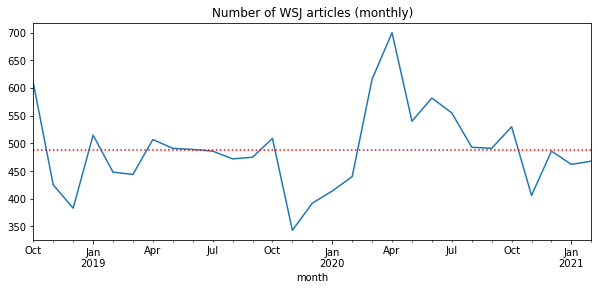

In [101]:
######################################## EDA of WSJ dataset ##########################################
# number of articles (monthly)
month = df1.groupby(by = 'month').count()
month['Text'].plot(figsize = (10,4), title = 'Number of WSJ articles (monthly)')
plt.axhline(y=np.mean(month['Text']), color='r', linestyle=':')
plt.show()

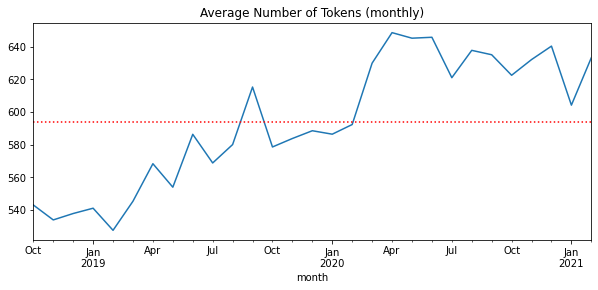

In [102]:
# average number of words
words = df1.groupby(by = 'month').mean()
words['No_Token'].plot(figsize = (10,4), title = 'Average Number of Tokens (monthly)')
plt.axhline(y=np.mean(words['No_Token']), color='r', linestyle=':')
plt.show()

In [103]:
print('Number of articles before COVID-19: ', np.mean(month['Text'][:15]))
print('Number of articles after COVID-19: ', np.mean(month['Text'][15:]))

Number of articles before COVID-19:  465.8666666666667
Number of articles after COVID-19:  513.0714285714286


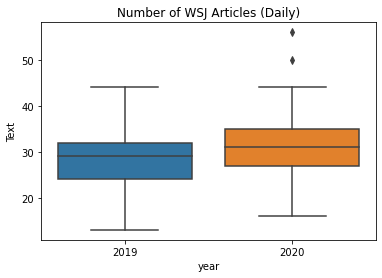

In [123]:
df2 = df1.groupby(by=['Date', 'year']).count().reset_index()
df2['year'] = df2['year'].apply(lambda x: int(str(x))) # convert period to int
df2 = df2[(df2['year'] == 2019) | (df2['year'] == 2020)][['year', 'Text']]

sns.boxplot(x="year", y="Text", data=df2)
plt.title('Number of WSJ Articles (Daily)')
plt.show()

/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

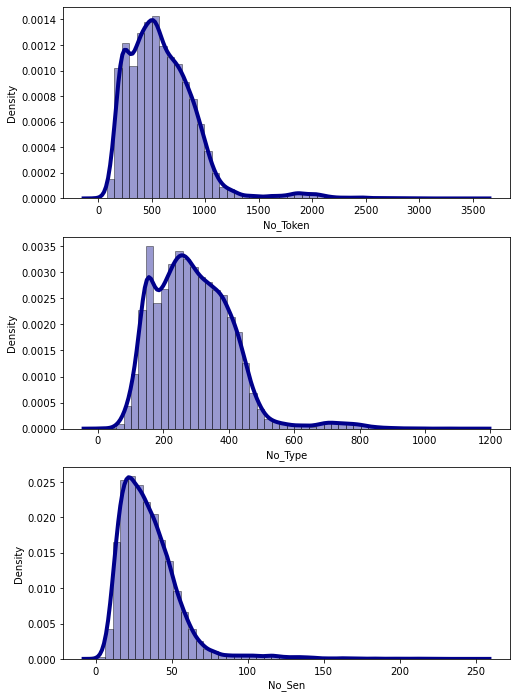

In [132]:
fig, axes = plt.subplots(3, 1, figsize = (8, 12))
sns.distplot(df1['No_Token'], hist=True, kde=True, 
             bins=int(50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax = axes[0])

sns.distplot(df1['No_Type'], hist=True, kde=True, 
             bins=int(50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax = axes[1])

sns.distplot(df1['No_Sen'], hist=True, kde=True, 
             bins=int(50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, 
             ax = axes[2])
plt.show()

In [136]:
df1[df1['direction'] == 'DOWN']

,Text,Date,direction,No_Sen,No_Token,No_Type,month,year
68,Sales of beverages in PepsiCo Inc.'s home mark...,2018-10-03,DOWN,29,408,216,2018-10,2018
69,When a wildfire engulfed the Canadian oil-sand...,2018-10-03,DOWN,103,1987,744,2018-10,2018
70,Retailer J.C. Penney & Co. has appointed Jill ...,2018-10-03,DOWN,22,277,168,2018-10,2018
71,As a new leader takes over at General Electric...,2018-10-03,DOWN,51,1032,409,2018-10,2018
72,U.S. companies are putting savings from the co...,2018-10-03,DOWN,40,698,328,2018-10,2018
...,...,...,...,...,...,...,...,...
14166,\nStocks turned higher after Federal Reserve C...,2021-02-25,DOWN,46,710,367,2021-02,2021
14167,\nMarkets are signaling that an economy that p...,2021-02-25,DOWN,55,1015,490,2021-02,2021
14168,\nFacebook Inc. said it would spend at least $...,2021-02-25,DOWN,18,378,188,2021-02,2021
14169,\nJohnson & Johnson's single-dose Covid-19 vac...,2021-02-25,DOWN,52,961,369,2021-02,2021


In [139]:
########################## t-test #####################################
# H_o: the number of tokens/types/sentences are the same for the upward and downward movement date
from scipy import stats

def t_test(x):
    a = df1[df1['direction'] == 'UP'][x]
    b = df1[df1['direction'] == 'DOWN'][x]
    return stats.ttest_ind(a, b, equal_var=False)

In [140]:
t_test('No_Token') ### the number of tokens

Ttest_indResult(statistic=0.3392173533370852, pvalue=0.734451299869987)

In [141]:
t_test('No_Type') ### the number of unique tokens

Ttest_indResult(statistic=0.1873322075191302, pvalue=0.8514030139886695)

In [142]:
t_test('No_Sen') ### the number of sentences

Ttest_indResult(statistic=0.35812585448200224, pvalue=0.7202547550329348)

In [173]:
######################### keyness analysis, word cloud ##############################
# clean the corpus
# load stopping words
import spacy
import re
import string

sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words # list of stop words

# remove 'up', 'down' from stop words
for st in ["above", "below", "up", "down", "on", "off", "over", "under", "few", "more", "most"]:
    try:
        all_stopwords.remove(st)
    except KeyError:
        continue


def clean_text(text):
    text = re.sub(r'[^\w\s]','', text) #remove punctuation
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    words = list(textcleaner.tokenize_by_word(text)) # tokenize the words
    words = [wo for wo in words if not wo in all_stopwords] # remove stop words
    return words
    

In [174]:
df1['corpus'] = df1['Text'].apply(lambda x: clean_text(x))

In [176]:
## wordcloud of upward and downward movement date
pos = list(df1[df1['direction'] == 'UP']['corpus'])
pos = sum(pos, []) # flatten the list
pos_str=(" ").join(pos)

neg = list(df1[df1['direction'] == 'DOWN']['corpus'])
neg = sum(neg, []) # flatten the list
neg_str=(" ").join(neg)

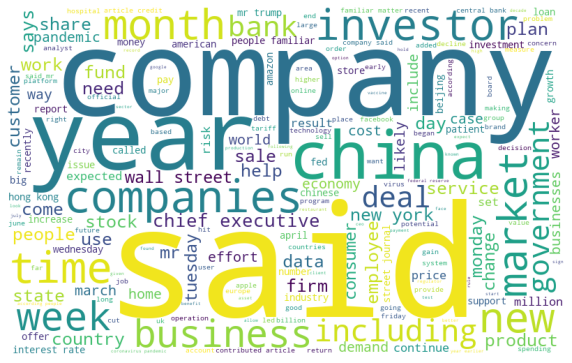

In [177]:
from wordcloud import WordCloud
wd1 = WordCloud(width = 800, height = 500,
               background_color ='white').generate(pos_str)
plt.figure(figsize=(10,10))
plt.imshow(wd1)
plt.axis("off")
plt.savefig("upward_wordcloud.png", bbox_inches='tight')
plt.show()


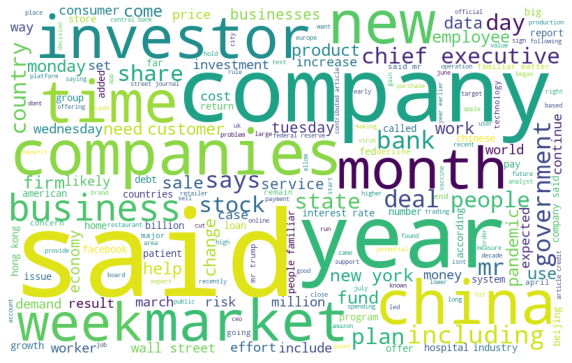

In [179]:
wd2 = WordCloud(width = 800, height = 500,
               background_color ='white').generate(neg_str)
plt.figure(figsize=(10,10))
plt.imshow(wd2)
plt.axis("off")
plt.savefig("downward_wordcloud.png", bbox_inches='tight')
plt.show()

In [181]:
#### keyness analysis
df1['year'] = df1['year'].apply(lambda x: int(str(x)))

before = list(df1[df1['year'] < 2020]['corpus'])
before = sum(before, []) # flatten the list
before_str=(" ").join(before)

after = list(df1[df1['year'] >= 2020]['corpus'])
after = sum(after, []) # flatten the list
after_str=(" ").join(after)

In [182]:
from collections import Counter

def word_count(string):
    li = list(string.split(' '))
    count = dict(Counter(li))
    count_df = pd.DataFrame.from_dict(count, orient = 'index') #convert the dict to dataframe
    count_df = count_df.reset_index()
    count_df.columns = ['Words', 'Freq']
    count_df = count_df.sort_values(by = ['Freq'], ascending = False)
    return count_df

before_count = word_count(before_str)
after_count = word_count(after_str)

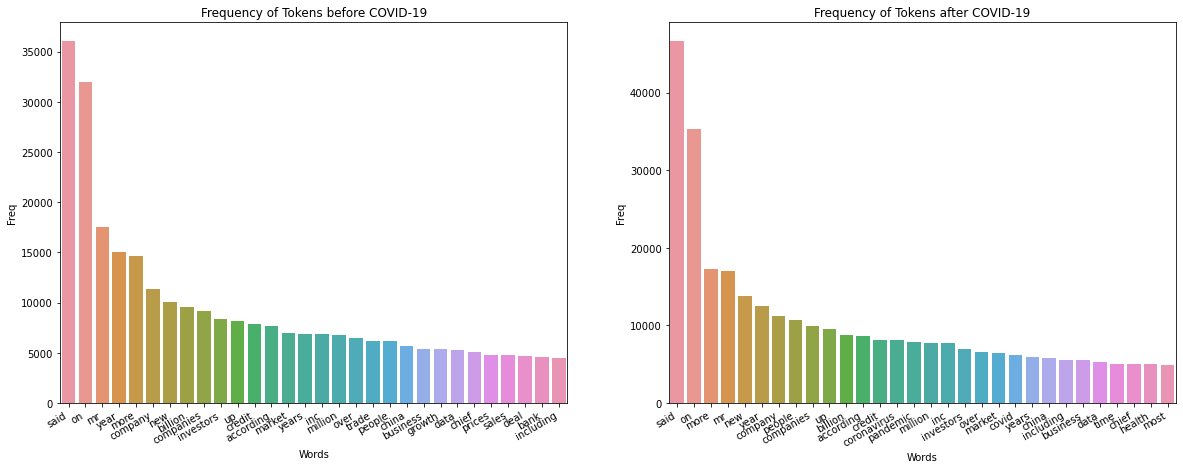

In [189]:
fig, axes = plt.subplots(1,2, figsize = (20, 7))

before_plt = sns.barplot(x = 'Words', y = 'Freq', data = before_count.head(30), ax = axes[0])
before_plt.set_xticklabels(before_plt.get_xticklabels(), 
                          rotation=30, 
                          horizontalalignment='right',
                          fontsize = 10)

after_plt = sns.barplot(x = 'Words', y = 'Freq', data = after_count.head(30), ax = axes[1])
after_plt.set_xticklabels(after_plt.get_xticklabels(), 
                          rotation=30, 
                          horizontalalignment='right',
                          fontsize = 10)

axes[0].set_title('Frequency of Tokens before COVID-19')
axes[1].set_title('Frequency of Tokens after COVID-19')
plt.show()